In this notebook I will try and train a U-net to output the masks of synthetic bat-like calls that I've made spectrograms + masks of. The SNRs, call durations and shape of the calls in the spectrograms vary. Please refer to the previous notebook 'Generating masks for synthetic call data' for further reference.

Most of the code here is taken directly from https://www.depends-on-the-definition.com/unet-keras-segmenting-images/

In [1]:
import keras 
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
import pickle 
import numpy as np
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
# from sklearn.model_selection import train_test_split --> don't need this anyway as it's already separated

import tensorflow as tf


Using TensorFlow backend.


In [2]:
# let's load the data and make it into tensors : 
training_file = open('sound_spec_mask//training_data.pkl', 'rb')
training = pickle.load(training_file)
training_file.close()

In [3]:
testing_file = open('sound_spec_mask//test_data.pkl', 'rb')
testing = pickle.load(testing_file)
testing_file.close()

In [4]:
validn_file = open('sound_spec_mask//validation_data.pkl', 'rb')
validation = pickle.load(validn_file)
validn_file.close()


In [5]:
# reshape everything as it needs to be for the U-net
def reshape_and_normalise(data_container):
    filenames = data_container.keys()
    num_files = len(filenames)
    img_rows, img_cols = data_container[filenames[0]]['specgm'].shape
    num_channels = 1 
    fin_rows, fin_cols = 128, 128

    image_tensor = np.zeros((num_files,fin_rows, fin_cols, num_channels))
    mask_tensor = np.zeros((num_files, fin_rows, fin_cols, num_channels))
    for i, each_file in enumerate(filenames):
        img_raw = data_container[each_file]['specgm']
        norm_img = img_raw/np.max(img_raw)
        norm_img = np.reshape(norm_img, (img_rows, img_cols, 1))
        resized_normimg = resize(norm_img, (128, 128, 1), mode='constant', preserve_range=True)
        
        mask_img_raw = data_container[each_file]['mask_specgm']
        mask_img = np.reshape(mask_img_raw, (img_rows, img_cols, 1))
        resized_mask_img = resize(mask_img, (128, 128, 1), mode='constant', preserve_range=True)
        threshold = np.percentile(resized_mask_img.flatten(), 99)
        resized_mask_img[resized_mask_img >= threshold] = 1 
        resized_mask_img[resized_mask_img < threshold] = 0
        
        
        image_tensor[i,:,:,:] = resized_normimg
        mask_tensor[i,:,:,:] = resized_mask_img
 
    return(image_tensor, mask_tensor)

In [6]:
training_img, training_mask = reshape_and_normalise(training)
validation_img, validation_mask = reshape_and_normalise(validation)
test_img, test_mask = reshape_and_normalise(testing)

/home/tbeleyur/anaconda2/envs/deeplearning/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
%matplotlib notebook

In [8]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [9]:
def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [10]:
im_height = 128
im_width = 128
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
# serialize model to JSON
model_json = model.to_json()
with open("batca;;_unet.json", "w") as json_file:
    json_file.write(model_json)

<IPython.core.display.Javascript object>


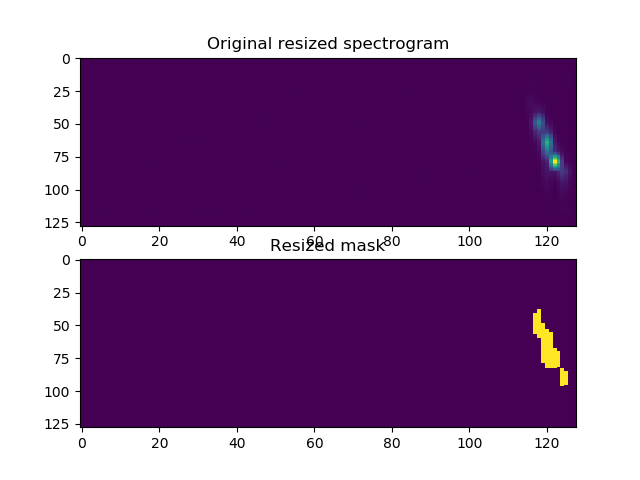

In [114]:
i = 50
plt.figure()
plt.subplot(211)
plt.title('Original resized spectrogram')
plt.imshow(training_img[i,:,:,:].reshape(128,128), aspect='auto')
plt.subplot(212)
plt.title('Resized mask')
plt.imshow(training_mask[i,:,:,:].reshape(128,128), aspect='auto')

In [55]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [69]:
results = model.fit(training_img, training_mask, batch_size=32, epochs=10, callbacks=callbacks,
                    validation_data=(validation_img, validation_mask))

Train on 500 samples, validate on 500 samples
Epoch 1/10
500/500 [==============================] - 228s 455ms/step - loss: 0.4430 - acc: 0.9590 - val_loss: 0.2547 - val_acc: 0.9879

Epoch 00001: val_loss improved from inf to 0.25465, saving model to model-tgs-salt.h5
Epoch 2/10
500/500 [==============================] - 216s 432ms/step - loss: 0.2426 - acc: 0.9936 - val_loss: 0.1663 - val_acc: 0.9943

Epoch 00002: val_loss improved from 0.25465 to 0.16629, saving model to model-tgs-salt.h5
Epoch 3/10
500/500 [==============================] - 216s 432ms/step - loss: 0.1829 - acc: 0.9957 - val_loss: 0.1727 - val_acc: 0.9948

Epoch 00003: val_loss did not improve from 0.16629
Epoch 4/10
500/500 [==============================] - 216s 432ms/step - loss: 0.1541 - acc: 0.9962 - val_loss: 0.1636 - val_acc: 0.9955

Epoch 00004: val_loss improved from 0.16629 to 0.16362, saving model to model-tgs-salt.h5
Epoch 5/10
500/500 [==============================] - 217s 434ms/step - loss: 0.1334 - ac

<IPython.core.display.Javascript object>


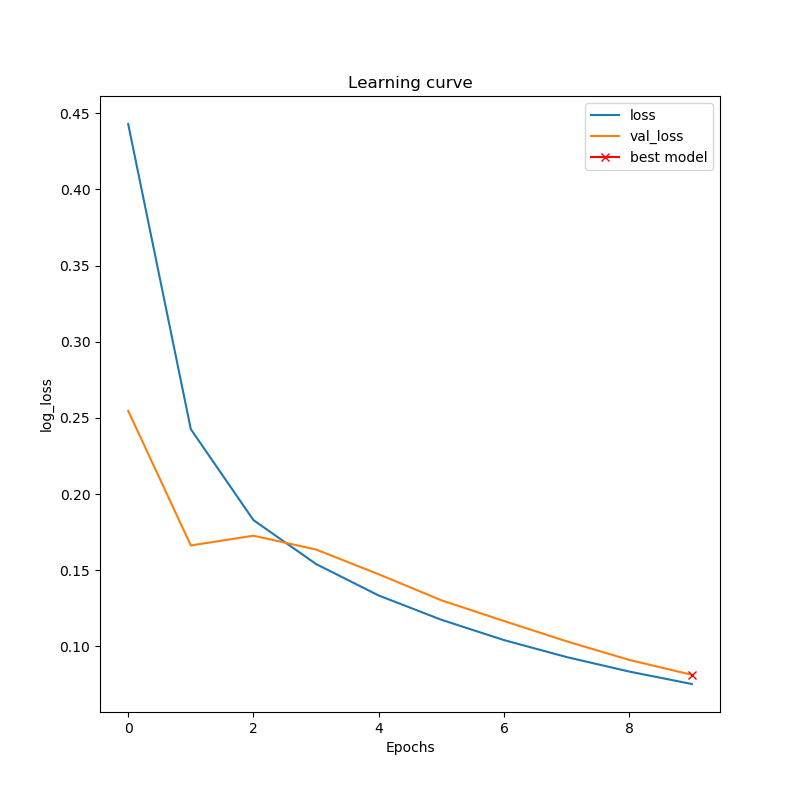

In [70]:
#copy pasted code from the post : 
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

And now let's try out the performance of the model:

In [103]:
preds_val = model.predict(test_img, verbose=1)

200/200 [==============================] - 17s 84ms/step


In [136]:
predicted_masks_file = open('sound_spec_mask/predicted_test_masks.pkl', 'wb')
pickle.dump(preds_val, predicted_masks_file)
predicted_masks_file.close()

<IPython.core.display.Javascript object>


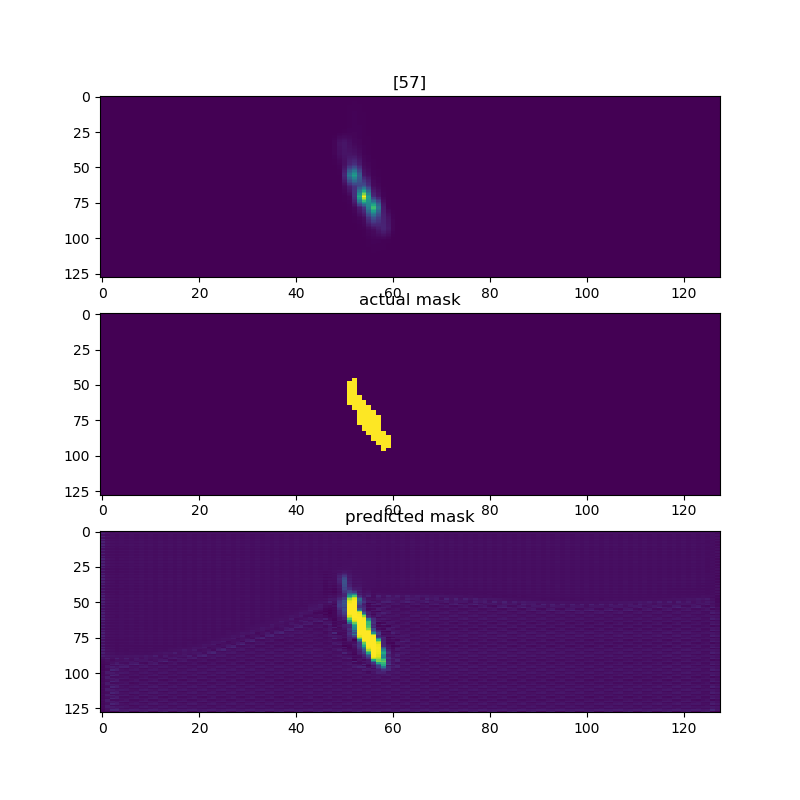

In [132]:
img_ind = np.random.choice(test_img.shape[0],1)
plt.figure(figsize=(8,8))
plt.subplot(311)
plt.title(str(img_ind))
plt.imshow(test_img[img_ind,:,:,:].reshape(128,128), aspect='auto')
plt.subplot(312)
plt.title('actual mask')
plt.imshow(test_mask[img_ind,:,:,:].reshape(128,128), aspect='auto')
plt.subplot(313)
plt.title('predicted mask')
plt.imshow(preds_val[img_ind,:,:,:].reshape(128,128), aspect='auto')

The outputs of the trained network look pretty neat. I'd like to now resize the predicted masks, and compare how well the masks are able to recover the call intensity... but I think I'll leave this to another notebook to avoid filling up this one too much !!